# Distribution approximation with sampling methods

## <font color="green"> Partie 1 :

On considère la loi de densité 
$$f(x,y)=Ce^{-x-y-xy}1_{\mathbb{R}^{+}}(x)1_{\mathbb{R}^{+}}(y)$$

### <font color="#00008"> Q-1) Calculer C :

Théoriquement, on ne peut pas avoir une valeur explicite de $C$ n'ayant pas une forme théorique de la primitive de la densité de la distribution.
Ainsi, on repose sur les méthodes d'approximation d'intégrale :

En effet, on peut écrire : $$\mathcal{J} = \int \frac{1}{C}f(x,y)dxdy=\int \mathcal h(x,y)\mathcal g(x,y)dxdy$$ 
Où : 
- $\mathcal g(x,y)=e^{-x-y}1_{\mathbb{R}^{+}}(x)1_{\mathbb{R}^{+}}(y)$ est une densité (produit de densités exponentielles). 
- $h(x,y)=e^{-xy}$ est la fonction qu'on évalue avec les samples générés par $f$. 
Ainsi, on se ramène à calculer l'espérance : $E_{X\sim f}(\mathcal{h})$. La bonne nouvelle est qu'on peut bien sampler en utilisant f, puisque sa densité est connue. Ainsi, une statistique sans bias et à variance asymptotique en $\sqrt n$, de $\mathcal{J}$ est : $$\mathcal{\hat{J}}=\frac{1}{n}\sum_{i=1}^{n}\mathcal{h(x_i)}, \;\;\; where\; x_1, x_2,...,x_n\sim \mathcal{f}$$

- #### En utilisant MCMC :

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot') #Used to give a pretty look to our plots

In [348]:
def h(x,y):
    return np.exp(-1*x*y)

def C(xs, ys, nbr_samples):
    J_estim=0
    for i in range(nbr_samples):
        J_estim+=h(Xs[i], Ys[i])
    return (1/J_estim)*nbr_samples

nbr_samples=10000
Xs=np.random.exponential(1, size=nbr_samples)
Ys=np.random.exponential(1, size=nbr_samples)

print("C with a number of samples={0} is : {1}".format(nbr_samples, C(Xs, Ys, nbr_samples)))

C with a number of samples=10000 is : 1.6710794420807396


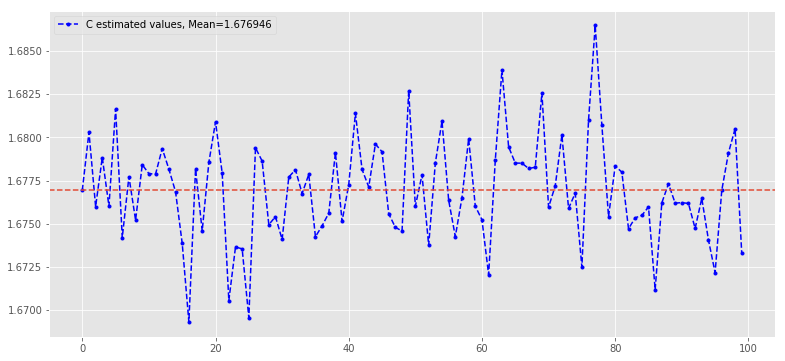

In [308]:
# multiple estimations of C
Cs=[]
nbr_samples_list=[100000]
nbr_sims_each_sample=100
for nbr_samples in nbr_samples_list:
    for i in range(nbr_sims_each_sample):
        Xs=np.random.exponential(1, size=nbr_samples)
        Ys=np.random.exponential(1, size=nbr_samples)
        Cs.append(C(Xs, Ys, nbr_samples))
        
plt.figure(figsize=(13,6))
plt.plot(Cs,'b.', label="C estimated values, Mean={}".format(round(np.mean(Cs),6)), linestyle="--")
plt.axhline(np.mean(Cs),linestyle="--")
plt.legend()
plt.show()

In [349]:
# Variance of C value on the computed values
np.var(Cs)

8.445026274210815e-06

<font color="blue"> **As a result of our MCMC method, a good estimation of $C$ with a very small variance ($\sim 9,9.10^{-6}$) is $C=1,67709$** 

- #### En utilisant l'intégration avec **Scipy** (basée sur la formule de Gauss–Kronrod):
(https://en.wikipedia.org/wiki/Gauss%E2%80%93Kronrod_quadrature_formula)

In [310]:
from scipy import integrate
import math

f_joint_proba= lambda x, y: np.exp(-x-y-x*y)
integrale=integrate.dblquad(f_joint_proba, 0, math.inf, lambda x: 0, lambda x: math.inf)
print("C = {0} avec une erreur de {1}".format(1/integrale[0], integrale[1]))

C = 1.6768750281798812 avec une erreur de 1.4825813759023756e-08


<font color="blue"> **As a result of Scipy integration,  a good estimation of $C$ with a small error ($\sim 1,48.10^{-8}$) is $C=1,6768$** 

### <font color="#00008"> Q-2) Calculer la loi conditionnelle de $X$ sachant $Y$ , puis de $Y$ sachant $X$ :

On note la densité jointe $f$ de $X$ et $Y$ par $f_{(X,Y)}$, la densité de marginale de $Y$ par $f_Y$. On a pour $y \;\;(tq,\;\; f_Y (y)\neq0)$ $$ f_{X|Y=y}(x)=\frac{f_{(X,Y)}(x,y)}{f_Y (y)}$$
Ainsi, il suffit de calculer la densité marginale, et étant donné que $f(x,y)=f(y,x)$ (symétrie), alors $f_X=f_Y$.

Où, $$f_Y (y)=\int f_{(X,Y)}(x,y)dx \\
 \;\;\;\;\;\;\;\;=\int f_{(X,Y)}(x,y)dx=\int_{\mathbb{R}^{+}}Ce^{-x-y-xy}dx\\
 \;\;\;\;\;\;\;\;=C\int_{\mathbb{R}^{+}}e^{-(1+y)x}e^{y}dx=\frac{C}{1+y}e^{-y}\big[ -e^{-x(1+y)}\big]_{0}^{+\infty}\\
 \boxed{f_Y (y)=\frac{C}{1+y}e^{-y}}$$
 
 Ainsi, $$\boxed{ f_{X|Y=y}(x)= \frac{Ce^{-x-y-xy}1_{\mathbb{R}^{+}}(x)}{\frac{C}{1+y}e^{-y}}
 =(1+y)e^{-x(1+y)}1_{\mathbb{R}^{+}}(x)1_{\mathbb{R}^{+}}(y)\\
 f_{Y|X=x}(y)=(1+x)e^{-y(1+x)}1_{\mathbb{R}^{+}}(y)}
 $$
 
 On note bien que les lois marginales sont des lois exponentielles $f_Y \sim \mathcal{E}(1+x), \;f_X \sim \mathcal{E}(1+y)$

### <font color="#00008"> Q-3) Proposer un algorithme MCMC pour simuler une chaîne de Markov de distribution invariante f :

Nous disposons des lois conditionnelles de $X$ et de $Y$. Ainsi, on peut échantilloner une chaîne de markov qui converge vers la loi conjointe $f$, en utilisant un **Gibbs Sampling** :

$$\boxed{
1) Initialisation : (x^{1},y^{1})\\
2) \big\{^{x^{t+1}\sim f_{X|Y=y^{t}}}_{y^{t+1}\sim f_{Y|X=x^{t+1}}}\\
3) Itérer\; jusqu'à\; convergence\; vers\; la\; loi\; invariante\; (ici\; la\; loi\; conjointe\; f)}$$

In [346]:
from scipy import stats
# Initialisation
x1, y1=np.random.random(size=2)
# Draws storage
Xs, Ys=[x1],[y1]
N_conv=1000000 # convergence number of iterations
lambda_Y=1+x1
for i in range(N_conv):
    xt_plus_1=np.random.exponential(1/lambda_Y, size=1)[0] # sample from conditional distribution of X
    Xs.append(xt_plus_1)
    lambda_X=1+xt_plus_1
    yt_plus_1=np.random.exponential(1/lambda_X, size=1)[0] # sample from conditional distribution of Y
    Ys.append(yt_plus_1)
    lambda_Y=1+yt_plus_1

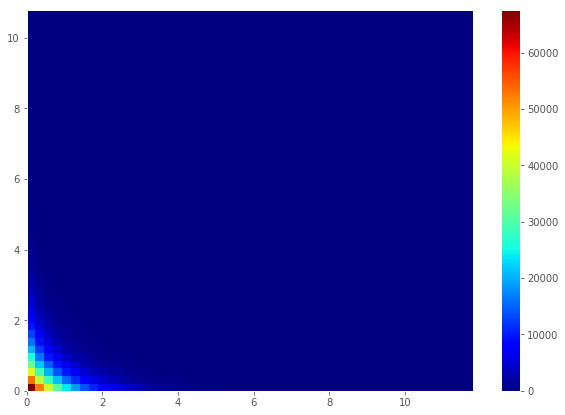

In [347]:
# We here draw a 2d histogram for the distribution
import seaborn as sns

plt.figure(figsize=(10,7))
plt.hist2d(Xs, Ys, bins=(50, 50), cmap=plt.cm.jet)
plt.colorbar()
plt.show()

<font color="blue"> **Discussion :**
    
We clearly see that the distribution generated with trhe gibbs sampling is concentrated in 0. I wanted to draw samples from the original distribution (throughouth the instanciation of a continuous distribution using **scipy.stats.rv_continuous** class to compare them to the gibbs sampling results, but this approach is computationnaly costly. 

## <font color="green"> Partie 2 :

### <font color="#00008"> Q-1) Echantillonner la distribution $\frac{1}{3}\mathcal{N}(-1,1)+\frac{2}{3}\mathcal{N}(2,\frac{3}{2})$ par un algorithme d’acceptation-rejet de votre choix :

On procède par l'algorithme d'**Accept-Rejet**, en faisant appel la densité proposale de Cauchy, $g(x)=\frac{1}{\pi (1+x^{2})}$.

La mise en oeuvre de cette méthode nécessite de connaître $M$ (une borne supérieur de $\frac{f}{g}$ On montre pour cela, que le rapport $$\mathcal{h}(x)=\frac{f(x)}{g(x)}=\sqrt{\frac{\pi}{2}}\big(\frac{1}{3} e^{-\big(\frac{x+1}{2}\big)^{2}}+\frac{4}{3}  e^{-\big(\frac{x-2}{3}\big)^{2}}\big)\big(1+x^{2}\big)$$
En dérivant la relation $(8)$ et calculant, à la main la valeur de la dérivée en 2 et en 5, on a $\frac{d\frac{f(x)}{g(x)}}{dx}\big |_{x=2}>0, \;\;\frac{d\frac{f(x)}{g(x)}}{dx}\big |_{x=5}<0$. Ainsi, le théorème des valeurs intermidiaires nous dit que  $h(x)=\frac{f(x)}{g(x)}$ admet un extrêmum sur l'intervalle $\big[2\;,\;5\big]$ (la dérivé première de $h$, étant aussi croissante sur cet intervalle, alors $h$ admet un maximum atteint sur l'intervalle $\big[2\;,\;5\big]$. (On pourrait mieux approximer l'intervalle en procédant par dichotomie)

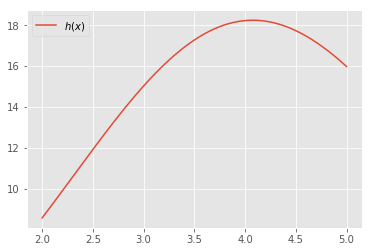

In [269]:
def h_fg(x):
    return np.sqrt(np.pi/2)*(1+x**2)*((1/3)*np.exp(-((x+1)/2)**2)+(4/3)*np.exp(-((x-2)/3)**2))

x_M_range=np.linspace(2,5,10000)# range of possible values of the maximizing x value of h
M_range=h_fg(x_M_range)
plt.plot(x_M_range, M_range, label="$h(x)$", markersize=20)
plt.legend()
plt.show()

M=max(M_range)

In [271]:
import scipy.stats as stat
#densité de la loi de cauchy
def g(x) : 
    return stat.cauchy.pdf(x)
# densité de la loi du mélange des deux gaussiennes
def f(x) :
    return (1/3)*stat.norm.pdf(x, loc=-1, scale=1)+(2/3)*stat.norm.pdf(x, loc=2, scale=3/2)

In [272]:
# génération d'une valeur suivant la loi uniforme 
U = stat.uniform.rvs(size = 1)
# génération d'une valeur suivant la loi de cauchy
x = stat.cauchy.rvs(size = 1 )
# liste des valeurs acceptées
X=[]
while len(X) < 10000 :
    if (f(x)/(M*g(x))) > U  :
        X.append(x)
    U = stat.uniform.rvs(size = 1)
    x = stat.cauchy.rvs(size = 1 )
X = np.array(X)

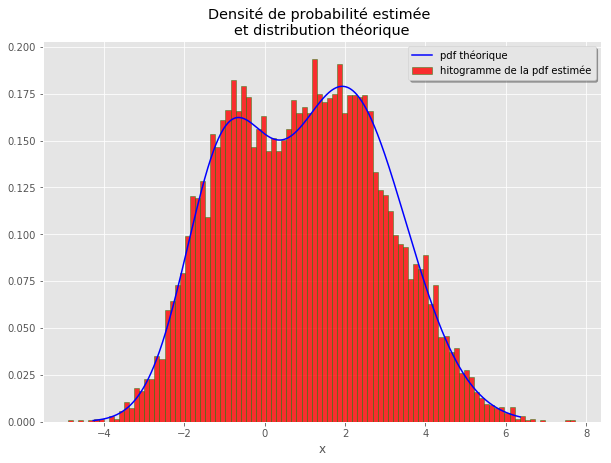

In [267]:
plt.figure(figsize=(10,7))

n_norm, bins_norm, patches = plt.hist(X, bins =100 , label ="hitogramme de la pdf estimée", alpha=0.8, density=True,color="red",  edgecolor ="green")

plt.xlabel("x")
plt.title("Densité de probabilité estimée \net distribution théorique")
plt.grid(True)
# tracer de la loi normale normalisé 
X2 = np.linspace(stat.norm.ppf(0.00001),stat.norm.ppf(0.9999999999), 10000)
plt.plot(X2,f(X2), color='blue', label="pdf théorique")
plt.legend(loc = "upper right" , shadow =True)
plt.show()

In [296]:
from scipy.stats import ks_2samp
print("the p_value of the Kolmogorov-Smirnov test is : {}, and the KS statistic is {}".format(ks_2samp(X.reshape(-1,), f(X2))[0], ks_2samp(X.reshape(-1,), f(X2))[1]))

the p_value of the Kolmogorov-Smirnov test is : 0.6275999999999999, and the KS statistic is 0.0


<font color="blue"> **Discussion :**
    
On peut bien voir que la méthode du sampling **Accept-Rejet** est très efficace dans l'échantillonnage du mélange des deux gaussiennes données. Chose, qu'on voit bien avec les distributions estimée qui embrasse la sa forme théorique. Un résultat renforcé par le test de **Kolmogorov-Smirnov**, qui valide qu'on ne peut pas rejeter l'hypothèse que les deux échantillons proviennenet de la même distribution.  

### <font color="#00008"> Q-2) Echantillonner la distribution $\frac{1}{4}\mathcal{N}(-1,2)+\frac{1}{2}\mathcal{N}(2,\frac{3}{2})+\frac{1}{4}\mathcal{N}(9,1)$ par l’algorithme de Metropolis-Hastings.

Comme fonction candidate (proposal), on va simplement choisir une loi ,normale dont le support contient le support de $f_2$. Ainsi, il suffit de choisir une distribution normale dont la moyenne est $\mu = \frac{max(\mu_i)- min(\mu_i)+1}{2}=\frac{11}{2}=4,5$ et dont l'écart type est suffisamment grand pour inclure les zones de probabilité prépondérante des trois ditributions. Par exemple $\sigma = 7$

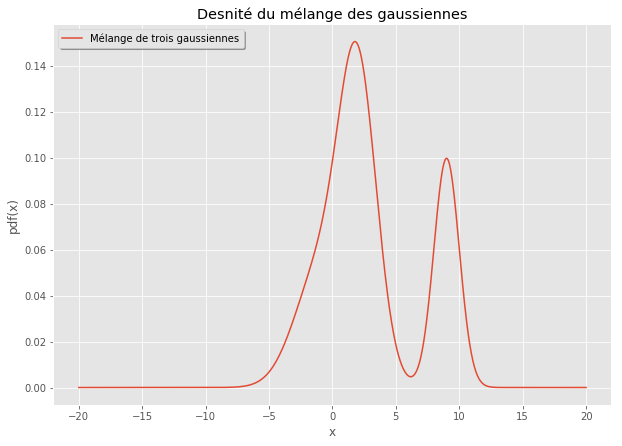

In [275]:
def f_2(x) :
    return (1/4)*stat.norm.pdf(x, loc=-1, scale=2)+(1/2)*stat.norm.pdf(x, loc=2, scale=3/2)+(1/4)*stat.norm.pdf(x, loc=9, scale=1)

x= np.linspace(-20,20,1000)

plt.figure(figsize=(10,7))
plt.plot(x,f_2(x), label = "Mélange de trois gaussiennes")
plt.title("Desnité du mélange des gaussiennes")
plt.xlabel("x")
plt.ylabel("pdf(x)")
plt.legend(loc = "upper left", shadow = True)
plt.grid(True)
plt.show()

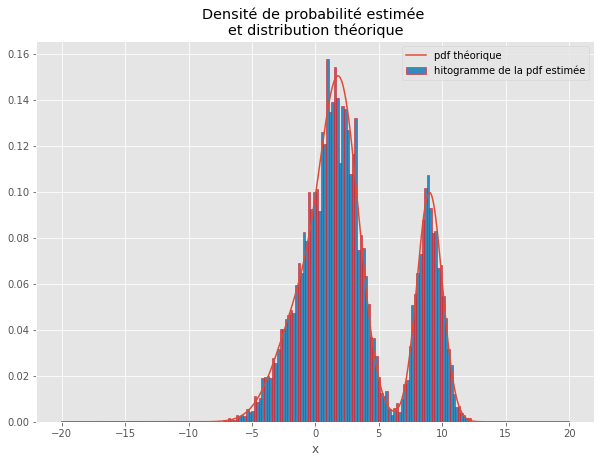

In [290]:
mu_proposal, sigma_proposal=4.5, 7 
# Définition de la fonction candidate (proposal)
def q(y):
    return stat.norm.pdf(y, loc=mu_proposal,scale=sigma_proposal)
# définition de rho
def rho_2(x,y) :
    return min(((f_2(y)*q(x))/(f_2(x)*q(y))),1)

# implementation de l'algorithme
y = stat.norm.rvs(loc =mu_proposal , scale =sigma_proposal, size=20000)
x0 = stat.uniform.rvs(loc = 2.5, scale =20, size = 1) # random initialisation
L_2  = []
L_2.append(x0[0])
for i in range(20000) : 
    u=stat.bernoulli.rvs(rho_2(L_2[-1],y[i])) # On effectue les tirage avec un échantillonneur de Bernouilli 
    if u==1 :
        L_2.append(y[i])  
    else :
        L_2.append(L_2[-1])
        
Values_2 = np.array(L_2[1001:]) # We cut after some iterations to have a better smple that converges to the invariant distribution

plt.figure(figsize=(10,7))
x= np.linspace(-20,20,len(Values_2))
plt.plot(x,f_2(x), label="pdf théorique")
plt.grid(True)
n, bins,patches=plt.hist(Values_2,bins= 100 , edgecolor= 'red',label ="hitogramme de la pdf estimée", density=True)
plt.xlabel("x")
plt.title("Densité de probabilité estimée \net distribution théorique")
plt.legend()
plt.show()

In [300]:
print("the p_value of the Kolmogorov-Smirnov test is : {}, and the KS statistic is {}".format(ks_2samp(Values_2, f_2(x))[0], ks_2samp(Values_2, f_2(x))[1]))

the p_value of the Kolmogorov-Smirnov test is : 0.7563684210526316, and the KS statistic is 0.0


<font color="blue"> **Discussion :**

L'échantillonnage avec **Metropolis-Hastings** est aussi très efficace. On voit bien qu'on arrive à obtenir des échantillons qui épousent la vraie distribution de la densité dumélange gaussien avec un test K-S validant cette hypothèse à une probabilité considérable (la p-value). Ceci rend cette méthode d'échantillonage très robuste, surtout qu'on a utilisé uniquement une distribution normale simple pour échantillonner le mélange des trois gaussiennes.